In [1]:
from mentalhealthcleaner import *
from statisticalcleaning import *
from featureengineering import *
from mentalhealthclassifer import *
from populationreg import *
import validatecolumns as vc
from mlmodelanalyzer import *


# Anxiety and Depression: Predicting the Population Percentage of Symptom Experience in Demographic Groups - Part 2 of 2

## Feature Engineering and Data Preprocessing

In [2]:
engineering = FeatureEngineerML(task_type='both', random_state=42)
clean_pop_df = engineering.upload_updated_cleaned_df(engineering.dataframe_file_path)
clean_pop_df.head(5)

,Indicator,Group,State,Subgroup,Phase,Time_Period,Time_Period_Start_Date,Time_Period_End_Date,Value,Low_CI,High_CI,Quartile_Range,Phase_Date_Specification
0,Symptoms of Depressive Disorder,National Estimate,United States,United States,1.0,1,04/23/2020,05/05/2020,23.5,22.7,24.3,23.5 - 27.4,NaN
1,Symptoms of Depressive Disorder,By Age,United States,18 - 29 years,1.0,1,04/23/2020,05/05/2020,32.7,30.2,35.2,32.7 - 36.9,NaN
2,Symptoms of Depressive Disorder,By Age,United States,30 - 39 years,1.0,1,04/23/2020,05/05/2020,25.7,24.1,27.3,25.7 - 31.4,NaN
3,Symptoms of Depressive Disorder,By Age,United States,40 - 49 years,1.0,1,04/23/2020,05/05/2020,24.8,23.3,26.2,24.2 - 27.7,NaN
4,Symptoms of Depressive Disorder,By Age,United States,50 - 59 years,1.0,1,04/23/2020,05/05/2020,23.2,21.5,25.0,23.2 - 27.9,NaN


Before inserting all the features into the ML models, the DataFrame structure was preprocessed to generate several new features. Overall, the new modified dataset was returned as the object **updated_pop_df**. Using the class `FeatureEngineerML,` which was initialized by the object engineering, the following features were engineered for the new DataFrame and in preparation for the data to be inserted into the ML models:

 * "**Survey_Start_Month**," "**Survey_Start_Day**," and "**Survey_Start_Year**": These columns were generated because the ML model cannot process the data type "DateTime." Instead, we break apart the month, day, and year of the start date and insert them. This is more important as a question that the Bureau asked was whether they had been experiencing symptoms in the last 7 days (or 2 weeks prior to 2021).
 * "**Survey_Start_Quarter**": This will be important, along with the month component, because as the periods progress, the seasonality of exposure to the disorders changes, which can be tracked and learned by the ML model, especially the regression-task ML model. With this column, four additional features can be generated in conjunction with the column "**Survey_Start_Month**": "**month_sin**," "**month_cos**," "**quarter_sin**," and "**quarter_cos**." These four columns allow the ML model to consider the time series information in a cyclical pattern and to learn seasonality rates for anxiety disorder, depressive disorder, and both. It also allows both models to identify any patterns that may be found about the times of the year.
 * "**days_since_baseline**": Allows the ML model to understand how many days had passed since the first day the survey collection had started (April 23, 2020).
 * "**Survey_Duration**": Showcased the length of time that it took to collect the subset of data
 * "**Survey_Quarter_Period**": As previously mentioned, this was one of the main components that needed to be derived for the interaction terms. This column was derived using the newly derived column
 * "**days_since_baseline**" which had its values then distributed among four quartiles and categorized between four classes (Period_1, Period_2, Period_3, and Period_4)

In [3]:
updated_pop_df = engineering.obtaining_basic_temporal_features(clean_pop_df, date_columns=['Time_Period_Start_Date', 'Time_Period_End_Date'])
updated_pop_df = engineering.length_of_survey_duration(updated_pop_df, date_columns=['Time_Period_Start_Date','Time_Period_End_Date'])
updated_pop_df = engineering.changes_to_phase_column(updated_pop_df, phase_column='Phase')

 * "**uncertainty_level**" and "**log_uncertainty_level**": This column described the confidence interval widths prior to the values undergoing a logarithmic transformation (for the classification model) and with a logarithmic transformation (for the regression model). 
 * "**data_realiability**" is a binary flag column that was engineered and determined if the piece of data that was obtained can be considered reliable. This column flagged a "1" whenever the uncertainty was higher than the 0.25-quartile bin generated through a distribution cut.
 * "**value_position**" - where does the value in regards to the confidence interval width
 * "**relative_uncertainty**" - captures uncertainty as a percentage of the value within the same index
 * "**multiplicative_error**": allowed analysis of how much the estimate could be multiplied or divided by to showcase different patterns within the uncertainty
 * "**uncertainty_ratio**": Compares the confidence interval uncertainty to the quartile range uncertainty
 * "**quartile_width**": provided the uncertainty (width) of the quartile range

In [4]:
updated_pop_df = engineering.generate_all_statistical_features(updated_pop_df, statistical_columns=['Low_CI', 'High_CI', 'Quartile_Range'])

 * "**age_group**": Provided a classification of the groups if they were aggregated from the microdata based on their age. The labels were obtained as a generalization of classifications from the World Health Organization Classification and in agreement with several websites, and six new classes were created specifically for this column.
 * "**education_level**": Provided a classification to the groups based on the aggregation that had been obtained from the original dataset and created five classes based on the responses that were initially on the US Census Household Pulse Survey Data Tables.
 * "**disability_status**": Provided a classification for the groups based on their disability status and generated three classes based on the responses from the US Census HPS Data Tables.
 * "**sexual_orientation_group**": Provided a classification for the groups based on their sexual orientation and generated four classes based on the responses from the US Census HPS Data Tables.
 * "**sex_at_birth_group**": Provided a classification for the groups based on their sex at birth and generated three classes based on the responses from the US Census HPS Data Tables.
 * "**gender_group**": Provided a classification for the groups based on their gender identity and generated four classes based on the responses from the US Census HPS Data Tables.
 * "**ethnicity_race_group**": Provided a classification for the groups based on their ethnicity and race and generated six classes based on the responses from the US Census HPS Data Tables.
 * "**us_divisional_region**": For each state, the states were now divided and mapped to their respective divisions according to the nine divisions established by the US Census Bureau. 
 * "**is_national_data**": A binary flag which highlights if the data in the current index is national data (1) or not (0).
 * "**population_type_analyzed**": This column informs the ML model as to what kind of aggregation from the microdata occurred at this entry and generated 10 classifications.

In [5]:
updated_pop_df = engineering.creating_demographic_groups(updated_pop_df)

 * All of the effects of the interaction were also generated under the following column names: "**age_sex_birth_interact**," "**age_gender_identity_interact**," "**age_sexual_orientation_interact**," "**educ_age_interaction**," and "**us_division_time_interact**."


In [6]:
updated_pop_df = engineering.creating_key_interaction_effect(updated_pop_df)

After all the new features were generated, the DataFrame was inspected once again and reviewed to analyze the features currently within it and to begin categorizing them as either "categorical" or "numerical." Furthermore, the method implemented filled any null values that may have appeared with "Unknown," which will later be ignored by the transformers. To indicate its completion, the method provided output information on the total number of features it was able to find and the updated shape of the DataFrame.

In [7]:
updated_pop_df = engineering.preparing_features_for_ML_models(updated_pop_df)

Total Number of Features Prepared: 30 total
Number of Categorical features: 17
Number of Numerical Features: 13
Updated shape of DataFrame: (16087, 49)


Once the features have been categorized, the target variables can be extracted as pandas Series objects, which were initialized as **reg_target** and **clf_target**. The logarithmic transformation was conducted on the object **reg_target**, so the regression model will only work with the logarithmic values for training purposes.

In [8]:
updated_pop_df, reg_target, clf_target, reg_orig = engineering.create_target_variables(updated_pop_df, use_log=True)

Target Variables have been modified based on changed which have been allowed.
Logarithmic Transformation applied: True


Prior to moving forward with data pipelining, validation needs to occur both within the classification target variable and in the columns. Within the classification variable, a small EDA analysis was conducted, and it was observed that there is a slight imbalance (a 2-point difference in the lowest and highest counts); however, it can be considered very balanced overall. This is crucial to inspect as we progress with the Multi-Class classification task. We need to ensure that the data is balanced because if it is imbalanced, we will obtain very skewed and biased results from the ML model.

In [9]:
clf_target.value_counts().sort_index()

Indicator
0    5361
1    5363
2    5363
Name: count, dtype: int64

Column validation had occurred prior to inserting the DataFrame structure into the pipelines as well. When inspecting the columns, we ensure that they are categorized correctly and that all columns are listed prior to being inserted into a Pipeline or a Transformer, as this can become very time-consuming if a mistake occurs. 

In [10]:
dictionary = vc.validate_dataframe_columns(updated_pop_df, engineering, engineering.task_type, verbose=True)

Column Validation Process Beginning:
{'Phase_Date_Specification', 'Value', 'Indicator'}
Datetime column found: Time_Period_Start_Date
Datetime column found: Time_Period_End_Date
Updated Number of Columns Available: 44
Number of available columns: 44
Conflict was resolved for column: month_sin
Conflict was resolved for column: month_cos
Conflict was resolved for column: phase_normalized
Total Number of Conflicts resolved: 3


Finally, data pipelining can begin. All categorical features were encoded using the `HotEncoder()` class from the `sklearn` library, while the numerical features were standardized using the z-score method with the `StandardScaler().` If the `HotEncoder()` transformer encountered an 'Unknown' label, it was instructed to ignore it, and both transformers were positioned through a `ColumnTransformer().` Any columns that were not processed through the `ColumnTransformer()` were then dropped from the dataset and no longer included. This preprocessor was fit with a clean version of the dataset (where the target variables were both removed to prevent target leakage). 

Afterwards, a test pipeline was generated using the `Pipeline` class and conducted a cross-validation check to determine the optimal number of features that the models could use. In this case, the Pipelines had implemented a logistic regression model for the classification task and a linear regression model for the regression task. The method returned a dictionary containing the results for both the regression model and the classification model, as well as the optimal number of features (k) that could be used for each respective model. In the case of this project, the regression model had an optimal number of 29 features, while the classification model had an optimal number of 6 features.



In [11]:
results, k_best = engineering.cross_validation_feature_selection_k(updated_pop_df, y_reg=reg_target, y_clf=clf_target)

Preprocessed X Shape: (16087, 2582)
Cross Validation completed. Optimal k-values found were {'regression': 29, 'classification': 6}


Sequentially, the pipelines can be obtained using the optimal values for feature selection (k), and a dictionary was created that contains both the pipelines needed to build the ML models. The objects **reg_pipeline** and **clf_pipeline** separate the two different pipelines for building the ML models.

In [12]:
pipelines = engineering.obtain_preprocessing_pipelines()
reg_pipeline = pipelines['regression']
clf_pipeline = pipelines['classification']

## Building and Training the ML Models

Now that the data has been pipelined and preprocessed, the ML models were all built and developed. Two objects were initialized: **CLF** for the `MentalHealthClassifier` and **REG** for the `PopulationPercentRegressor,` respectively, to assist in building and finding the optimal ML model for the specific task.

In [13]:
CLF = MentalHealthClassifier(fe_instance=engineering, task_type='both', test_size=0.3, random_state=42)
REG = PopulationPercentRegressor(fe_instance=engineering, task_type='both', test_size=0.3, random_state=42)

Prior to building any ML models or testing, the data was split into separate datasets for classification and regression models. A total of 8 objects were created, as the classification models cannot utilize the logarithmic columns that the regression models use, and different features are implemented within the dataset even though they have the same number of data entries.

In [14]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = CLF.prepare_clf_data_for_modeling(updated_pop_df, clf_target)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = REG.prepare_reg_data_for_modeling(updated_pop_df, reg_target)


11260 in train data, 4827 in test data prepared for the classification data for the ML models.
11260 in train data, 4827 in test data prepared for the classification data for the ML models.


Within the method *CLF.build_clf_models(X_train, y_train, prepipeline, use_grid_search)* or *REG.build_clf_models.(X_train, y_train, prepipeline, use_grid_search)*, the same formula is used, but it contains the various models that are being tested for this project. It also provided an opportunity for the method to optimize the parameters for each model prior to eliminating any models, allowing for fine-tuning of the hyperparameters. For the classification-model version, the `SGDClassifier(),` `GradientBoostingClassifer(),` and `LogisticRegression()` were all tested with varying hyperparameters. In the regression-model version, `MLPRegressor(),` `GradientBoostingRegressor(),` and `LinearRegression()` were all tested and cross-validated side by side with varying hyperparameters prior to returning a dictionary that contained the results of all of the varying hyperparameters. The method also updated **self.best_model** within the program to identify the best model for both the regression task and the classification task within their respective classes.

As a result, it was obtained that the best model for the classification task was the GradientBoostingClassifier and the best model for the regression task was the GradientBoostingRegressor.

In [15]:
clf_results = CLF.build_clf_models(X_train_clf, y_train_clf, clf_pipeline, use_grid_search=True)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [16]:
CLF.best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Time_Period', 'Low_CI',
                                                   'High_CI',
                                                   'days_since_baseline',
                                                   'Survey_Start_Day',
                                                   'quarter_sin', 'quarter_cos',
                                                   'uncertainty_level',
                                                   'value_position',
                                                   'relative_uncertainty',
                                                   'quartile_width',
                                                   'month_sin', 'month_cos',
                                                   'phase_normalized']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                han...
                                                   'population_type_analyzed',
                                                   'age_sex_birth_interact',
                                                   'age_gender_identity_interact',
                                                   'age_sexual_orientation_interact',
                                                   'educ_age_interaction',
                                                   'us_division_time_interact'])])),
                ('feature_selector', SelectKBest(k=6)),
                ('model',
                 GradientBoostingClassifier(learning_rate=np.float64(0.03125),
                                            max_features='sqrt',
                                            max_leaf_nodes=4, n_estimators=300,
                                            random_state=42))])

In [17]:
reg_results = REG.build_reg_models(X_train_reg, y_train_reg, reg_pipeline, use_grid_search=True)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [18]:
REG.best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Time_Period', 'Low_CI',
                                                   'High_CI',
                                                   'days_since_baseline',
                                                   'Survey_Start_Day',
                                                   'quarter_sin', 'quarter_cos',
                                                   'uncertainty_level',
                                                   'value_position',
                                                   'relative_uncertainty',
                                                   'log_uncertainty',
                                                   'multiplicative_error',
                                                   'quartile_width',
                                                   'uncertainty_ratio',
                                                   'month_sin', 'month_co...
                                                   'age_sex_birth_interact',
                                                   'age_gender_identity_interact',
                                                   'age_sexual_orientation_interact',
                                                   'educ_age_interaction',
                                                   'us_division_time_interact'])])),
                ('feature_selector',
                 SelectKBest(k=29,
                             score_func=<function f_regression at 0x000001E18E527F60>)),
                ('model',
                 MLPRegressor(alpha=np.float64(16.0), early_stopping=True,
                              max_iter=300, random_state=42, solver='lbfgs',
                              tol=0.001))])

## Results and Discussion

In [19]:
analyzer = MLModelAnalyzer(regression_results=reg_results, classification_results=clf_results)

## Results and Discussion
The project successfully generated two complementary ML models for the singular tabular dataset: a GradientBoostingClassifier for categorical diagnosis prediction on mental conditions and the MLP Regressor for predicting the percentage of the population that would display the symptoms of the classification. Both models demonstrated strong predictive performance and revealed important insights into the factors that could influence mental health outcomes, as well as factors that could bias results and lead to inaccurate predictions.

### Model Performance Results
When looking through the dictionary that contained all of the models and the results from the RandomizedSearchCV, the instance object **analyzer** found the best models with their respective scores, which showed that for the regression model, the MLP Regressor emerged as the optimal model for predicting the proportion of the population that would present with mental health symptoms, with a Mean Squared Error (MSE) of 0.0271 The model was configured using the `sklearn` library with optimal hyperparameters, which were identified as having. On the other hand, the GradientBoostingClassifier had an F1 Score of 0.5756 which was found for the F1 score. Although not as good, this is a good starting point to begin with as we are just began with 6 classification features. Futhermore, the other scores that were measured at this time were recall and precision, for which the GradientBoostingClassifier had scores of 0.5771 for precision and 0.5826. Retraining had been attempting on another program, but this was the highest we were able to make it achieve at this time. This might be once again due to the limitations of aggregated datasets that were mentioned previously, and not having as much numerical values to work with. Due to the limitations that were also occurring within the dataset, we were unable to acquire true feature importance at this time, but according to the Pipelines, the best features that were used were the following:

* Uncertainty Level
* Value Position
* Survey Quarter Period
* Age Group & Sex at Birth Interaction
* Geographic Division
* Relative Uncertainty

### Performance Metrics Analysis:

The F1 score was chosen in this situation, in addition to accuracy, because it allows for the inspection of the harmonic mean of precision and recall. Within the health sciences data, a majority of instances can occur where the data is imbalanced, and such an occurrence is happening here with the grouping of the information. Although the labels are not imbalanced themselves, the grouping, as we saw from the quartile range and value analysis, is skewed and imbalanced to a certain degree, making it more important to have the F1 score available for viewing the factual accuracy of the model.

The root mean square error (RMSE) was used for the regression model rather than just the mean squared error (MSE) because the RMSE allows the error to be expressed in the same units as the target value. Furthermore, it allows a balance to occur in error magnitude, where if we have too large an error, it can be a problem, and RSE magnifies those larger problems. This was important to find because even though we have a better score overall with the Gradient Boosting Regressor, the MLP Regressor overall had completed a much better performance and was able to handle the sparsed data better. However, improvement can be made upon with providing more hidden layers, or allowing for individualistic data and better response rates to occur.

In [20]:
best_models = analyzer.extract_best_models()

Gradient Boosting Regressor
Best Score: -0.0008520447600831306
Best Params: {'model__max_leaf_nodes': 7, 'model__learning_rate': np.float64(0.03125), 'model__criterion': 'squared_error'}
Multi-layer Perceptron Regressor
Best Score: -0.0004850170524229273
Best Params: {'model__solver': 'lbfgs', 'model__alpha': np.float64(16.0), 'model__activation': 'relu'}
Linear Regression
Best Score: -0.0004850170524229273
Best Params: {'model__solver': 'lbfgs', 'model__alpha': np.float64(16.0), 'model__activation': 'relu'}
SGD Classifier
Best Score: 0.4600352809569525
Best Params: {'model__loss': 'log_loss', 'model__learning_rate': 'optimal'}
Gradient Boosting Classifier
Best Score: 0.5653919378997702
Best Params: {'model__max_leaf_nodes': 4, 'model__learning_rate': np.float64(0.03125), 'model__criterion': 'friedman_mse'}
Logistic Regression
Best Score: 0.5432770863592151
Best Params: {'model__tol': np.float64(6.309573444801929e-05), 'model__solver': 'saga', 'model__C': np.float64(8.0)}


In [21]:
evaluation_results = analyzer.generating_performance_scores(X_test_reg, y_test_reg, X_test_clf, y_test_clf)

Gradient Boosting Regressor:
R2 Score: 0.9945
RMSE: 0.0245
MSE: 0.0006
------------------------------
Multi-layer Perceptron Regressor:
R2 Score: 0.9933
RMSE: 0.0271
MSE: 0.0007
------------------------------
Linear Regression:
R2 Score: 0.9933
RMSE: 0.0271
MSE: 0.0007
------------------------------
Classification_Logistic Regression:
R2 Score: -46.4936
RMSE: 2.2719
MSE: 5.1617
------------------------------
SGD Classifier:
F1 Score: 0.5647
Accuracy Score: 0.5730
Precision: 0.5645
Recall Score: 0.5730
------------------------------
Gradient Boosting Classifier:
F1 Score: 0.5756
Accuracy Score: 0.5826
Precision: 0.5771
Recall Score: 0.5826
------------------------------
Logistic Regression:
F1 Score: 0.5502
Accuracy Score: 0.5625
Precision: 0.5515
Recall Score: 0.5625
------------------------------


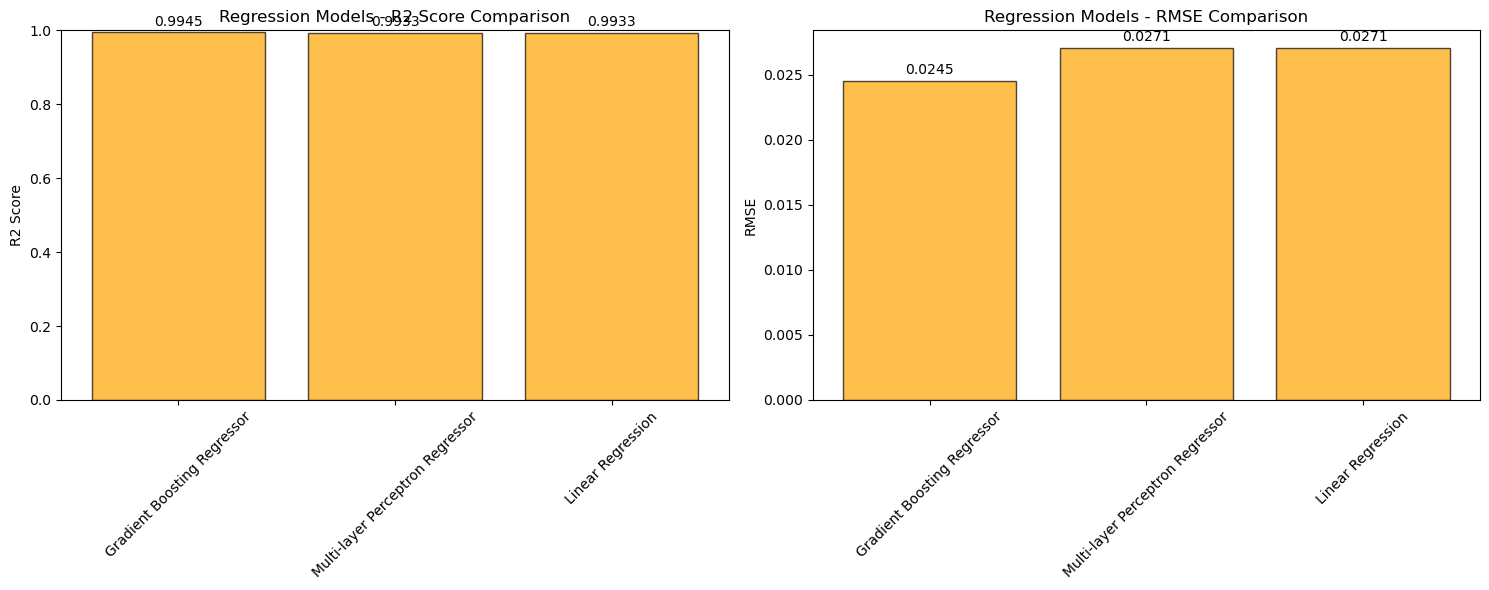

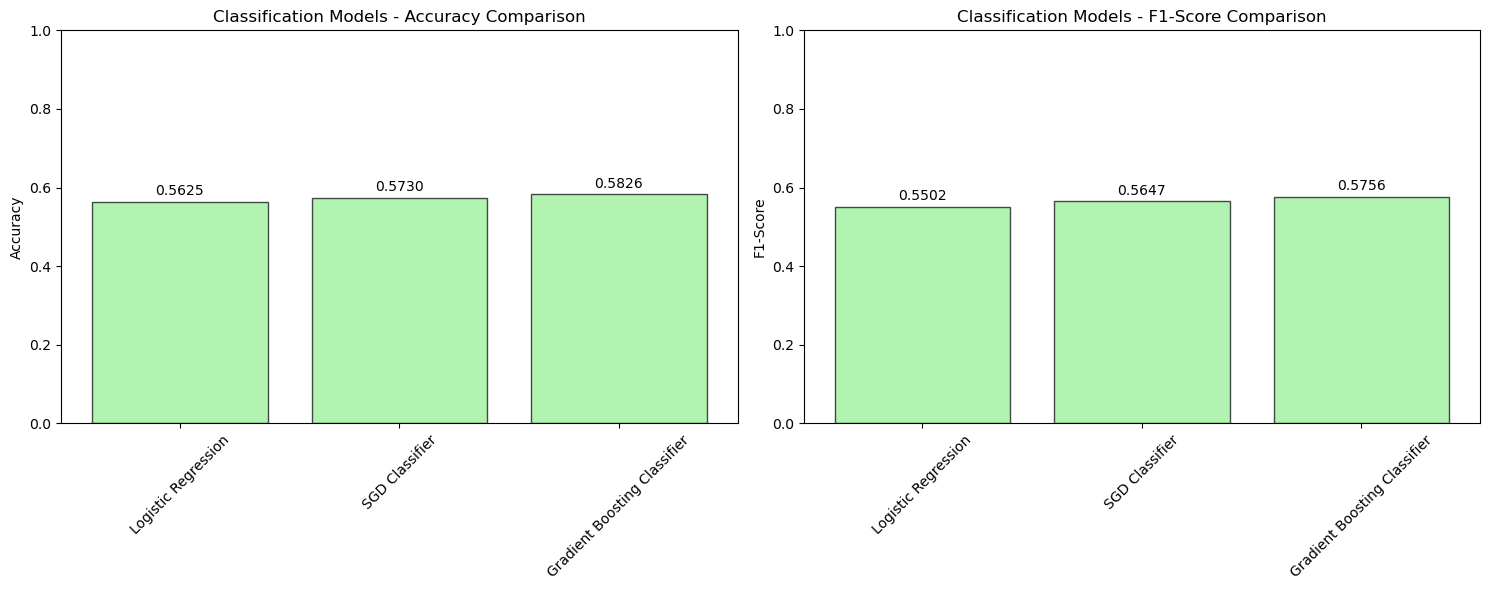

In [22]:
visualizations = analyzer.create_performance_plots()

## Conclusion
The complementary ML models have showcased a variety of practical applications as to how machine learning can be implemented within the healthcare world. An example is clinical screening - with these models, they can provide sufficient accuracy for preliminary mental health questionnaires and awareness for the public health community for demographic groups in their area who are at risk for anxiety and depressive disorder. Furthermore, it encourages the use of machine learning within the fields of population health surveillance and public health. With changes in geographic and temporal patterns, ML models can study and learn the patterns derived from these topics, correlating the matter at hand to identify optimal intervention strategies and moments when they are needed most, as well as where they should be implemented. However, there are considerable limitations that need to be considered when using ML models in the healthcare world, especially with aggregated data. When using aggregated data, certain demographic groups may be underrepresented, while others may be overrepresented due to location bias and sampling bias.

Furthermore, as healthcare data is often acquired through surveys completed by participants themselves, the participants may respond differently from the actual truth, thus generating a response bias and inherent bias within the ML results if they were to be used. On a technical level, due to feature selection, univariate tests isolate complex multivariate interactions that need to be highlighted and occur in the real world - some of which may cause or exacerbate the symptoms that the questionnaires were designed to address. Some improvements that could be recommended for the advancement of this model, should it be considered, would be to systematically explore and identify higher-order feature interactions (three or more interactions) that could be found through the data. Furthermore, an expansion of the questions would be suggested to assist in exposure to the accuracy of the labels, as specific individuals who do experience anxiety or depression may not respond to the questions that were given on the questionnaire by the US Census Bureau. Another suggestion would be to increase the GridSearch and to find hyperparameters with a cross-validation fold parameter of 5. However, with the information provided, these models have already demonstrated the superior performance of gradient-boosting approaches, especially for mental health predictions. It also showcased the importance of using temporal, geographic, and demographic features when analyzing healthcare data through ML models. It laid the foundation for future clinical translations and population health applications in the mental health field.

## References

CDCTobaccoFree. (2023, March 14). Depression and Anxiety. Centers for Disease Control and Prevention. [https://www.cdc.gov/tobacco/campaign/tips/diseases/depression-anxiety.html](https://www.cdc.gov/tobacco/campaign/tips/diseases/depression-anxiety.html)
  
Centers for Disease Control and Prevention. (2025). Indicators of Anxiety or Depression Based on Reported Frequency of Symptoms During Last 7 Days (No. 850c51718b8205ba3bdfc5124b2adb2d7a43d1122ea92c099abc73259dbe9c40) [CSV]. Data.gov. https://catalog.data.gov/dataset/indicators-of-anxiety-or-depression-based-on-reported-frequency-of-symptoms-during-last-7-

Diamond, F. (2021, February 1). Goodbye to January 2021, COVID-19’s Worst Month (So Far). Infection Control Today. https://www.infectioncontroltoday.com/view/goodbye-to-january-2021-covid-19-s-worst-month-so-far-

Halperin, S. J., Henderson, M. N., Prenner, S., & Grauer, J. N. (2021). Prevalence of Anxiety and Depression Among Medical Students During the Covid-19 Pandemic: A Cross-Sectional Study. Journal of Medical Education and Curricular Development, 8, 2382120521991150. https://doi.org/10.1177/2382120521991150

Kalin, N. H. (2020). The Critical Relationship Between Anxiety and Depression. American Journal of Psychiatry, 177(5), 365–367. https://doi.org/10.1176/appi.ajp.2020.20030305

Mishra, A. K., & Varma, A. R. (2023). A Comprehensive Review of the Generalized Anxiety Disorder. Cureus. https://doi.org/10.7759/cureus.46115

National Center for Health Statistics, & U.S. Census Bureau. (2025, February 7). Mental Health - Household Pulse Survey - COVID-19. https://www.cdc.gov/nchs/covid19/pulse/mental-health.htm

Penninx, B. W., Pine, D. S., Holmes, E. A., & Reif, A. (2021). Anxiety disorders. The Lancet, 397(10277), 914–927. https://doi.org/10.1016/S0140-6736(21)00359-7

U.S. Census Bureau. (2020). Source of the Data and Accuracy of the Estimates for the 2020 Household Pulse Survey - Phase 2. U.S. Census Bureau. https://www2.census.gov/programs-surveys/demo/technical-documentation/hhp/Phase2_Source_and_Accuracy-Week%2013.pdf

US Census Bureau. (2025a, April 15). Household Pulse Survey Data Tables. Census.Gov. https://www.census.gov/programs-surveys/household-pulse-survey/data/tables.html

US Census Bureau. (2025b, April 30). Household Pulse Survey: Measuring Emergent Social and Economic Matters Facing U.S. Households. Census.Gov. https://www.census.gov/data/experimental-data-products/household-pulse-survey.html